# Georectify Image

Firstly add the necessary paths (modify these to match the folders where you have located your CoastSnap GUI and the file where this Jupyter Notebook is located)

In [1]:
addpath('/Users/nickheaney/Desktop/CoastSnap/Code/GUI');
addpath('/Users/nickheaney/Desktop/CoastSnap-Jupyter-MATLAB')
load('Georectify_MATLAB.mat');

### 1. Get data about the selected image and the site from previous stages.
### 2. Check if the image has already been rectified.
### 3. Retrieve the GCP (ground control point) real world location information from the database.
### 4. Define the initial external camera parameters.
### 5. Prompt the user to interactively select the location of each GCP within the image:

The following demonstrates the interface that the user is provided with. Initially the cursor is a zoom in tool and after the press of any key, this becomes the tool for selecting the point. There is an issue with the use of this interface in Jupyter Notebook: the cursor does not change to the point selector. To see the full functionality, open MATLAB. Load the GCPs.mat (using: load('GCPs.mat')) and then run the content in the cell below to the command window.
<br>**note:** it is not an issue that the GCPs are not selected in this tutorial. A previously selected set of GCP locations is included in the variables imported at the beginning.

In [2]:
%plot native
image(I)
for i = 1: nGcps
        title((['GCP ' num2str(i) ' of ' num2str(nGcps) ': Digitize ' gcp(i).name]));
                % Let the mouse around and see the values.
                hPixelInfo = impixelinfo();
                set(hPixelInfo, 'Unit', 'Normalized', 'Position', [.45 .96 .2 .1]);
        % you can zoom with your mouse and when your image is okay, you press any key
        zoom on;
        pause()
        zoom off;
        UV(i,:) = ginput(1);
        hold on
        plot(UV(i,1),UV(i,2),'go', 'markerfacecolor', 'g', 'markersize', 3);
        zoom out
    end

the MATLAB function has been cancelled


### 6. Establish the unknown camera parameters

> #### 6.1 Create a range of focal length trial values:

Use the predefined (in the database) maximum and minimum horizontal field of view values to calculate the corresponding minimum and maximum focal lengths, between which a range of focal length trial values is defined. The relationship linking horizontal field of view is and focal length is:
$$HFOV = 2tan^{-1}\frac{N_{u}}{2f}$$

Where Nu is the image width in pixels.

In [2]:
HFOV_min = siteDB.rect.FOVlims(1); %From DB
    HFOV_max = siteDB.rect.FOVlims(2);%From DB
    fx_max = 0.5*inputs.cameraRes(1)/tan(HFOV_min*pi/360); %From Eq. 4 in Harley et al. (2019)
    fx_min = 0.5*inputs.cameraRes(1)/tan(HFOV_max*pi/360); %From Eq. 4 in Harley et al. (2019)
    fx_min = interp1([5:5:500000],[5:5:500000],fx_min,'nearest');
    fx_max = interp1([5:5:500000],[5:5:500000],fx_max,'nearest');
    fx = fx_min:5:fx_max;

> #### 6.2 For each focal length trial value, fit a non-linear regression of the function 'FindUVnDOF' using the least squares estimation relating the known world (xyz) coordinates and the image coordinates (UV) located within the image.

The function 'FindUVnDOF' applies the pinhole camera model to convert the UV coordinates to xyz coordinates: below is a summary of the model taken from Harley _et al.,_ 2019

$\begin{bmatrix} U \\ V \\ 1 \end{bmatrix} = P\begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix}$ &nbsp;&nbsp;&nbsp;&nbsp;
Where: $P = KR\begin{bmatrix} I & | & -C\end{bmatrix}$ ,&nbsp;&nbsp;&nbsp;&nbsp;    $K = \begin{bmatrix} f & s & p_{u} \\ 0 & \gamma f & p_{v} \\ 0 & 0 & 1 \end{bmatrix}$, &nbsp;&nbsp;&nbsp;&nbsp;**R** is the rotation matrix defined by azimuth (α), tilt (t) and roll (r), **I** is a 3x3 identity matrix, and **C** is a vector of the real world camera location (ie xyz)

The matrix **K** is simplified for its application in CoastSnap though the following assumptions:
-	Skew, **s**, is 0.
-	The pixel coordinates of the principle points, **pu** and **pv** are at the image centre.
-	The pixels are square so the pixel aspect ratio, **γ**, is 1.


Following these assumptions, the projection matrix, **P**, contains 4 unknowns
-	Focal length, **f**.
-	Azimuth, **α**.
-	Tilt, **t**.
-	Roll, **r**.

CoastSnap resolves the **focal length** separately to the other three unknowns: **azimuth**, **tilt** and **roll**. **Azimuth**, **tilt** and **roll** are resolved using the fit of a non linear regression of **findUVnDOF** for each of the trial values of the **focal length**. The **mean squared error** (mse) for each of the regressions is calculated, and the regression with the smallest mse is taken to represent the resolved **focal length**.

To demonstrate the application of the pinhole model, the relevant operations from **lcpBeta2P** (called from within **findUVnDOF**) have been extracted and presented here using example values for the input variables. These operations were also necessary in order to test the Python code (a same simplified version of **findUVnDOF** has been created and converted to Python to do so):

In [3]:
%input variables:
c0U = 1024;
c0V = 768;
fx = 1875;
fy = 1875;
beta = [0, 0, 17.3010, -0.3491, 1.3963, 0]; %beta is a representing [xCam, yCam, zCam, azimuth, tilt, roll]


K = [fx 0 c0U;
    0 -fy c0V;
    0  0 1]

R = angles2R(beta(4), beta(5), beta(6))
IC = [eye(3) -beta(1:3)']
P = K*R*IC


K =

        1875           0        1024
           0       -1875         768
           0           0           1


R =

    0.9397    0.3421         0
   -0.0594    0.1631    0.9848
   -0.3369    0.9254   -0.1736


IC =

    1.0000         0         0         0
         0    1.0000         0         0
         0         0    1.0000  -17.3010


P =

   1.0e+04 *

    0.1417    0.1589   -0.0178    0.3076
   -0.0147    0.0405   -0.1980    3.4254
   -0.0000    0.0001   -0.0000    0.0003



Below is a demonstration of the non-linear regression fit of **findUVnDOF**

In [4]:
load('nlinfit_findUVnDOF.mat')

In [5]:
inputs.beta0 = beta0;

[beta, R, ~, CovB, mse, ~] = nlinfit(xyz, [UV(:,1); UV(:,2)], 'findUVnDOF', inputs.beta0, options);

beta


beta =

   -0.1675    0.1197   17.1450   -0.4060    1.3034   -0.0050



In order to test python alternatives, the following simplification of **findUVnDOF** was produced and converted to Python (converting **findUVnDOF** exactly would not be valuable just for the task of testing non-linear fit functions in Python. The effectiveness of the non-linear fit functions can be assessed equally well with a simplified version.

**Note:** running the two cells bellow (which contain the functions TESTFITFUNC and angles2R) will produce an error since MATLAB functions cannot be defined in Jupyter Notebook. These functions are saved in the same file as this notebook so that they can operate, the code has been reproduced here for you to understand what is happening in each.

**TESTFITFUNC** below is a revision of **findUVnDOF** which excludes the **distort** function (used to re-distort pixel coordinates), which is obsolete here anyway (Harley _et al.,_ 2019). In addition, the initial lines of **findUVnDOF** are if statements to establish the number of inputs into the function and organise the variable in response. However, the input is always the same number here (beta0's length is always 6) and especially since I am using test variables which are always the same size, these initial lines not useful and can be excluded. **Note**: the output from **TESTFITFUNC** was identical to **findUVnDOF** for the extent of variables used to test and compare the two.

In [6]:
function [UV] = TESTFITFUNC(beta, xyz)

load('finalnonlinearfittest')
K = [fx 0 c0U;
    0 -fy c0V;
    0  0 1];

R = angles2R(beta(4), beta(5), beta(6));
IC = [eye(3) -beta(1:3)'];
P = K*R*IC;
P = P/P(3,4);

UV = P*[xyz'; ones(1,size(xyz,1))];
UV = UV./repmat(UV(3,:),3,1);

UV = [UV(1,:) UV(2,:)]';

Error: Function definition not supported in this context. Create functions in code file.



Where the rotation matrix, **R** is created by the following function **angles2R**:

In [7]:
function R = angles2R(a,t,s)

R(1,1) = cos(a) * cos(s) + sin(a) * cos(t) * sin(s);
R(1,2) = -cos(s) * sin(a) + sin(s) * cos(t) * cos(a);
R(1,3) = sin(s) * sin(t);
R(2,1) = -sin(s) * cos(a) + cos(s) * cos(t) * sin(a);
R(2,2) = sin(s) * sin(a) + cos(s) * cos(t) * cos(a);
R(2,3) = cos(s) * sin(t);
R(3,1) = sin(t) * sin(a);
R(3,2) = sin(t) * cos(a);
R(3,3) = -cos(t);

%   Copyright (C) 2017  Coastal Imaging Research Network
%                       and Oregon State University

Error: Function definition not supported in this context. Create functions in code file.



In [8]:
load('nlinfit_TESTFITFUNC.mat')

[beta, ~, ~, ~, mse, ~] = nlinfit(xyz, [UV(:,1); UV(:,2)], 'TESTFITFUNC', beta0)


beta =

   -0.1718    0.1558   17.1404   -0.4058    1.3028   -0.0056


mse =

   10.0105



Repeating the non-linear regression fit for all members in the range of possible focal lengths:

In [9]:
%redefining fx since it was reused after the range of trial values was defined:
    fx = fx_min:5:fx_max;

In [5]:
wb = waitbar(0,'Optimising camera focal length for image rectification....');

    for i = 1:length(fx)
        waitbar(i/length(fx),wb,'Optimising camera focal length for image rectification....');
        globs.lcp.fx = fx(i);
        globs.lcp.fy = fx(i);
        %Non-linear fit, output geometry, residuals, covariance matrix and mse
        [beta, R, ~, CovB, mse, ~] = ....
            nlinfit(xyz, [UV(:,1); UV(:,2)], 'findUVnDOF', inputs.beta0, options);
        
        % Compute confidence intervals for each of the fitted parameters
        
        MSEall(i) = mse;
    end
    close(wb)

In [6]:
%Find optimum focal length based on minimum MSE
[MSEmin,Imin] = min(MSEall);

In [7]:
FOVmin = rad2deg(2*atan(inputs.cameraRes(1)/(2*fx(Imin))));

In [8]:
disp(['Min RMSE of ' num2str(sqrt(MSEmin)) ' pixels found for FOV = ' num2str(FOVmin,'%0.1f') ' deg'])

Min RMSE of 3.6395 pixels found for FOV = 57.2 deg


In [9]:
globs.lcp.fx = fx(Imin);
globs.lcp.fy = fx(Imin);

The optimum focal length is:

In [10]:
globs.lcp.fx


ans =

        1880



### 7. Plot the GCP locations generated by the resolved camera parameters onto the image.

In [11]:
% Non-linear fit, output geometry, residuals, covariance matrix and mse
[beta, R, ~, CovB, mse, ~] = nlinfit(xyz, [UV(:,1); UV(:,2)], 'findUVnDOF', inputs.beta0, options);

In [12]:
betas = [0, 0, 17.3010, beta(4), beta(5), beta(6)]


betas =

         0         0   17.3010   -0.4069    1.3019   -0.0057



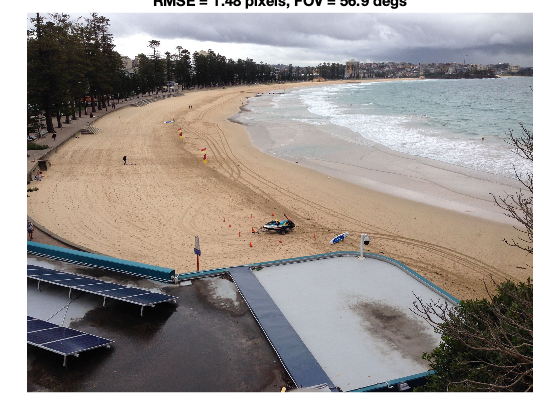

In [18]:
imshow(I)
hold ('on')
MSE = mse;
RMSE = sqrt(MSE);
title(sprintf('RMSE = %.2f pixels, FOV = %0.1f degs', RMSE,FOVmin));

In [19]:
%plot native


% Plot GCPs transformed in image coordinates by the fitted geometry
UV_computed = findUVnDOF(betas(1,:), xyz, globs);
UV_computed = reshape(UV_computed,[],2);
imshow(I)
hold('on')
plot(UV(:,1), UV(:,2), 'go', 'markerfacecolor', 'g', 'markersize', 3)
plot(UV_computed(:,1),UV_computed(:,2),'ro');

### 8. Create the plan image

Next, CoastSnap generates the new images structure by calling the function **buildRectProducts** (images = buildRectProducts(1, images, I, betas(1,:), meta.globals);). Here, the steps undertaken in **buildRectProducts** are followed:

Load the .mat file which has set the variables to match the **buildRectProducts** inputs and set up the variables:

In [13]:
load('build___Rect___Products.mat');
I = double(I);
[NV,NU,NC] = size(I);
Us = [1:NU];
Vs = [1:NV]';
xy = images.xy;
z = images.z;

Create grid axes (x and y) based on user defined parameters in the database. Then pass these to the **meshgrid** function:

In [14]:
x = [xy(1):xy(2): xy(3)]; y = [xy(4):xy(5): xy(6)];
[X,Y] = meshgrid(x,y);
images.sumI = zeros(length(y),length(x),3);
images.N = zeros(size(X));

Create an array representing the (x,y,z) coordinates of every point in the grid. Shape: (nPoints, 3)

In [15]:
xyz = [X(:) Y(:) repmat(z, size(X(:)))];

Create an array of (U,V) coords (rounded to nearest integer) corresponding to each grid point (with shape (n, 2)):

In [16]:
UV = round(findUVnDOF(beta,xyz,glob));
UV = reshape(UV,[],2);

Create an array denoting the (U,V) coordinates where pixel data exists with a 1: (**note** this is done using the **onScreen** function in CoastSnap).

In [17]:
U = UV(:,1);
V = UV(:,2);
Umin = 1;
Vmin = 1;
Umax = NU;
Vmax = NV;
yesNo = zeros(size(U,1),1);
on = find((U>=Umin) & (U<=Umax) & (V>=Vmin) & (V<=Vmax));
yesNo(on) = ones(size(on));

Generate array with the index of all the UV coords which will have pixel data:

In [18]:
good = find(yesNo);

Return the linear indices of the coordinates with pixel data:

In [19]:
ind = sub2ind([NV NU],UV(good,2),UV(good,1));
foo = images.sumI;

Extract the pixel data from the oblique image and allocate it to the associated grid coordinates.

In [20]:
for i = 1: 3    % for rgb, fill in snap content in rect frame
        I3 = I(:,:,i);
        I2 = I3(ind);
        bar = foo(:,:,i);
        bar(good) = I2;
        foo(:,:,i) = bar; 
end
images.dn = dn;
images.x = x;
images.y = y;
images.sumI  = foo;
images.xyz = xyz; % for later interp2
images.N(good) = 1;

Convert the points without pixel information to NaNs and plot the plan image:

In [21]:
N = repmat(images.N,[1 1 3]);
finalImages.x = images.x;
finalImages.y = images.y;
finalImages.timex = uint8(images.sumI./N);

In [25]:
%plot native
imagesc(finalImages.x,finalImages.y,finalImages.timex);
axis equal